<a href="https://colab.research.google.com/github/ernestoruizds/DS_C3_SC1_ERNESTO_RUIZ_SANCHEZ/blob/main/DS_C7_SC3_ERNESTORUIZSANCHEZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tensorflow==2.15.0

In [3]:
pip install keras==2.15.0

In [3]:
# Validamos que tanto keras como tensorflow tengan la misma versión para evitar incompatibilidad
# sobre todo, al momento de importar archivos con extensión .h5 provenientes de Teachable Machine
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

2.15.0
2.15.0


In [4]:
# Se importan las librerías necesarias
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random as rn
import pathlib
import cv2
import PIL

from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [7]:
##################################################################################################################
# 2. Extrae los archivos de la carpeta comprimida y sube los directorios a Google Drive para poder trabajar con ellos
##################################################################################################################
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

DIR_BASE = "/content/drive/MyDrive/M22/Reto/datos/objetos/"
DIR_UNSUPPORTED_FILES = "/content/drive/MyDrive/M22/Reto/datos/unsupported_files/"
DIR_AVION = DIR_BASE + 'avion'
DIR_COHETE = DIR_BASE+'cohete'
DIR_DRON = DIR_BASE+'dron'
DIR_HELICOPTERO = DIR_BASE+'helicoptero'
DIR_JET = DIR_BASE+'jet'
DIR_MISIL = DIR_BASE+'misil'

UN_DIR_AVION = DIR_UNSUPPORTED_FILES + 'avion/'
UN_DIR_COHETE = DIR_UNSUPPORTED_FILES +'cohete/'
UN_DIR_DRON = DIR_UNSUPPORTED_FILES +'dron/'
UN_DIR_HELICOPTERO = DIR_UNSUPPORTED_FILES +'helicoptero/'
UN_DIR_JET = DIR_UNSUPPORTED_FILES +'jet/'
UN_DIR_MISIL = DIR_UNSUPPORTED_FILES +'misil/'

DIR_BASE = pathlib.Path(DIR_BASE)

Mounted at /content/drive


In [7]:
############################################################################
# 3. Genera un cuaderno de Python en Google Colab para solucionar el reto.
# 4. Preprocesa la base de datos por poder trabajar con ella
############################################################################
# Función usada para averiguar si todas las extenciones de los archivos son iguales
def obtener_extension_archivos(DIR):
  ext=[]
  for archivo in os.listdir(DIR):
    nom_archivo, ext_archivo = os.path.splitext(archivo)
    ext.append(ext_archivo)
  extensiones=set(ext) # Crea un conjunto de la lista con la característica para no repetir valores
  print("Extensiones en directorio: " + DIR)
  print(extensiones)

obtener_extension_archivos(DIR_AVION)
obtener_extension_archivos(DIR_COHETE)
obtener_extension_archivos(DIR_DRON)
obtener_extension_archivos(DIR_HELICOPTERO)
obtener_extension_archivos(DIR_JET)
obtener_extension_archivos(DIR_MISIL)

# Se puede apreciar que en todas las carpetas hay archivos con diferentes extensiones
# como '.PNG', '.gif', '.php', '.axd', '.jpeg', '.png', '.cms', '.aspx', '.webp', '.66dc5b9c87', '.JPG', '.img', '.jpg' entre otras;
# así que será necesario filtrar sólo las imágenes con extensión jpg para poder construir la base de datos a trabajar
# De igual modo, se detectó que existen imágenes con extensión JPG que en realidad son imágenes conformato WEBP,
# las cuales no pueden ser usadas para el entrenamiento de la red, por lo que también serán descartadas

Extensiones en directorio: /content/drive/MyDrive/M22/Reto/datos/objetos/avion
{'.png', '.gif', '.aspx', '.JPG', '.webp', '.jpg', '.jpeg', '.bin', '.2'}
Extensiones en directorio: /content/drive/MyDrive/M22/Reto/datos/objetos/cohete
{'.png', '.gif', '.php', '.axd', '.img', '.66dc5b9c87', '.aspx', '.jpg', '.JPG', '.webp', '.jpeg', '.PNG', '.cms'}
Extensiones en directorio: /content/drive/MyDrive/M22/Reto/datos/objetos/dron
{'.png', '.gif', '.php', '.JPG', '.webp', '.jpg', '.jpeg', '.PNG', '.cms', '.5', '.ashx'}
Extensiones en directorio: /content/drive/MyDrive/M22/Reto/datos/objetos/helicoptero
{'.png', '.gif', '.jfif', '.php', '.axd', '.img', '.aspx', '.dpg', '.jpg', '.webp', '.JPG', '.jpeg', '.cls', '.PNG', '.ashx'}
Extensiones en directorio: /content/drive/MyDrive/M22/Reto/datos/objetos/jet
{'.png', '.gif', '.php', '.axd', '.img', '.66dc5b9c87', '.aspx', '.JPG', '.webp', '.jpg', '.jpeg', '.jp2', '.PNG', '.5'}
Extensiones en directorio: /content/drive/MyDrive/M22/Reto/datos/objetos/mi

In [8]:
Imagenes=[]    # Inicializar las listas donde estará la representación matricial de cada imagen
Etiquetas=[]   # y sus etiquetas correspondientes
IMG_TAM = 224  # Establece un tamaño estándar de 150 píxeles para todas las imágenes

def es_webp(archivo):
    with open(archivo, 'rb') as file:
        header = file.read(12)
        return header[:4] == b'RIFF' and header[8:] == b'WEBP'

# Función usada para validar si el archivo es de una imágen con ext jpg
def imagen_valida(archivo,extensiones=[".jpg"]):
    nom_archivo, ext_archivo = os.path.splitext(archivo)
    es_archivo = os.path.isfile(archivo)
    es_imagen = ext_archivo.lower() in extensiones
    return es_archivo and es_imagen

def limpia_base_datos(DIR, UN_DIR):
    for archivo in tqdm(os.listdir(DIR)):
        ruta = os.path.join(DIR,archivo)
        if not imagen_valida(ruta) or es_webp(ruta): # Si el archivo no es una imágen válida, el achivo se moverá a la carpeta de "unsupported_files"
            os.rename(ruta, UN_DIR + os.path.basename(archivo))

# Inputs:
# etiqueta: La etiqueta que se le asignará a las imágenes de cada carpeta
# DIR: La ruta de la carpeta que se va a procesar
def construir_base_datos(etiqueta, DIR):
    # El ciclo procesará cada una de las imágenes dentro de la carpeta seleccionada
    # y mostrará una barra de progreso por el uso de la biblioteca tqdm.

    for archivo in tqdm(os.listdir(DIR)):
        ruta = os.path.join(DIR,archivo) # Armamos la ruta del archivo a procesar
        img = tf.keras.preprocessing.image.load_img(ruta,color_mode='rgb') # Se carga el archivo
        matriz_img = tf.keras.preprocessing.image.img_to_array(img)        # Convertimos la imagen a una matriz
        # normalizamos los valores dentro de la matriz y redimencionamos la imagen a un tamaño de 150 x 150 pixeles
        matriz_img = tf.image.resize(matriz_img/255,[IMG_TAM,IMG_TAM])
        # La representación matricial dentro del tensor de la imagen es manejada como arreglo de numpy
        # debido a que es más fácil trabajar con enderays para la bilioteca sklearn que con tensores
        Imagenes.append(matriz_img.numpy()) # Se arma el set de imágenes
        Etiquetas.append(etiqueta)          # Se arma el set de etiquetas

# Se crea un vector con las clases a trabajar
clases=['avion','cohete','dron','helicoptero','jet','misil']


In [9]:
print('\n', "Iniciando proceso de depuración de archivos")
print("------------------------------------------------")
limpia_base_datos(DIR_AVION, UN_DIR_AVION)
limpia_base_datos(DIR_COHETE, UN_DIR_COHETE)
limpia_base_datos(DIR_DRON, UN_DIR_DRON)
limpia_base_datos(DIR_HELICOPTERO, UN_DIR_HELICOPTERO)
limpia_base_datos(DIR_JET, UN_DIR_JET)
limpia_base_datos(DIR_MISIL, UN_DIR_MISIL)



 Iniciando proceso de depuración de archivos
------------------------------------------------


100%|██████████| 1334/1334 [01:08<00:00, 19.54it/s] 


In [9]:
print('\n', "Iniciando proceso de creación de base de datos")
print("------------------------------------------------")
construir_base_datos(0,DIR_AVION)
construir_base_datos(1,DIR_COHETE)
construir_base_datos(2,DIR_DRON)
construir_base_datos(3,DIR_HELICOPTERO)
construir_base_datos(4,DIR_JET)
construir_base_datos(5,DIR_MISIL)


 Iniciando proceso de creación de base de datos
------------------------------------------------


100%|██████████| 1220/1220 [00:38<00:00, 31.75it/s]


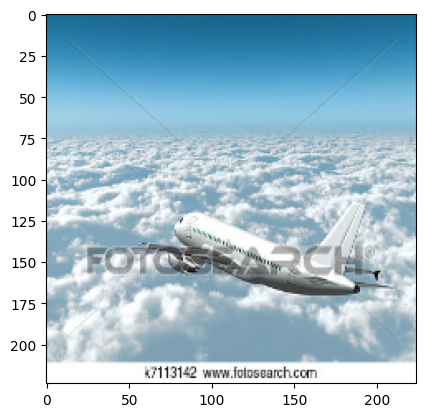

<Figure size 640x480 with 0 Axes>

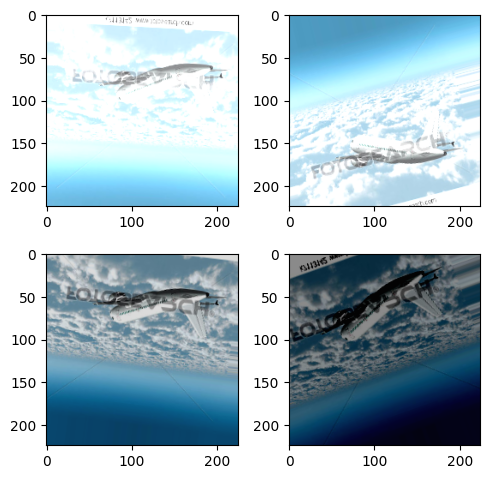

In [10]:
############################################################################
# 5. Genera los conjuntos de entrenamiento y prueba y haz un proceso de aumento de datos.
############################################################################
# Se crea el conjunto de entrenamiento con el 80% de las imágenes y el de prueba con el 20% restante
# Las listas generadas se convierten a arreglos de numpy (np.array)
img_entrenamiento,img_prueba,etq_entrenamiento,etq_prueba = train_test_split(Imagenes, Etiquetas, test_size=0.2, random_state=42)
img_entrenamiento = np.array(img_entrenamiento)
img_prueba = np.array(img_prueba)
etq_entrenamiento = np.array(etq_entrenamiento)
etq_prueba = np.array(etq_prueba)

# Data Augmentation
# El objeto datagen es el que realiazá 9 transformaciones sobre las imágenes
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 25,       # Rotación aleatoria de la imágenes en un rango de (0 a 25)
    zoom_range = 0.05,         # Acercamiento aleatorio dentro de la imagen
    width_shift_range = 0.1,   # Desplazamiento horizontal aleatorio
    height_shift_range = 0.1,  # Desplazamiento vertical aleatorio
    horizontal_flip = True,    # Rotación horizontal de las imágenes
    vertical_flip = True,      # Rotación vertical de las imágenes
    channel_shift_range = 0.5, # Modificación aleatoria de los valores RGB de la imagen
    shear_range = 0.2,         # La imágen se distorciona, como cuando los humanos cambiamos de ánguli
    fill_mode = 'nearest'      # Los puntos afuera de los límites de la entrada, se rellenan
    )


# Seleccionamos la primera imágen el conjunto de prueba  de aviones
# para ver cómo se aplican las transformaciones
data = img_prueba[0]
samples = np.expand_dims(data,0)
plt.figure()
plt.imshow(data)
plt.show()
plt.figure()
fig,ax = plt.subplots(2, 2)
fig.set_size_inches(5, 5)
it = datagen.flow(samples,batch_size = 1)
for i in range (2):
    for j in range (2):
        batch = next(it)
        image = batch[0]
        ax[i,j].imshow(image)
        plt.tight_layout()



In [12]:
################################################################
# 6. Genera tres modelos:
# a. El primer modelo debes diseñarlo desde cero creando la arquitectura
#    y configurando los hiperparámetros utilizando aumento de datos.
################################################################
RN = tf.keras.Sequential([
     tf.keras.layers.Flatten(input_shape=(IMG_TAM, IMG_TAM,3)), #Capa de entrada
     tf.keras.layers.Dense(256, activation='relu'), #Capa oculta
     tf.keras.layers.Dense(256, activation='relu'), #Capa oculta
     tf.keras.layers.Dense(128, activation='relu'), #Capa oculta
     tf.keras.layers.Dense(64, activation='relu'), #Capa oculta
     tf.keras.layers.Dense(6, activation='softmax') #Capa de salida
])

RN.summary()

RN.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

desempeno_RN = RN.fit(datagen.flow(img_entrenamiento, etq_entrenamiento, batch_size=128),
                      validation_data=(img_prueba,etq_prueba),
                      epochs=10,
                      batch_size=1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_5 (Dense)             (None, 256)               38535424  
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 6)                 390       
                                                                 
Total params: 38642758 (147.41 MB)
Trainable params: 3

In [13]:
# Guardamos el modelo construido
RN.save("/content/drive/MyDrive/M22/Reto/Modelo_1_redConv.keras")


1527/1527 [==============================] - 3s 2ms/step - loss: 1.7443 - accuracy: 0.2646
Conjunto de prueba exactitud: 0.26457104086875916
Conjunto de prueba función de perdida: 1.7442761659622192


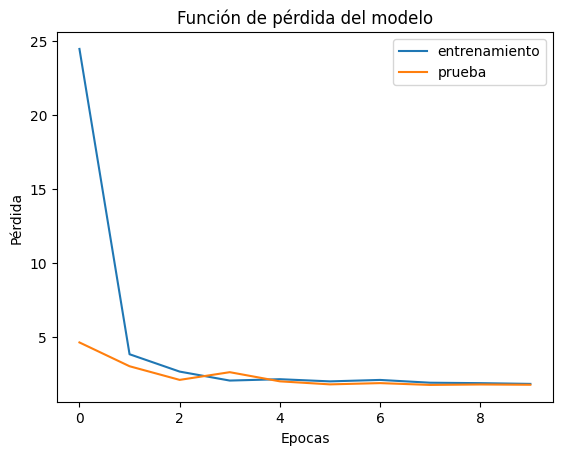

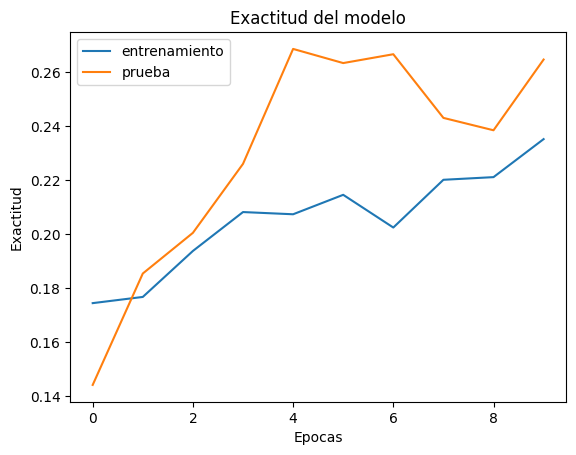

In [14]:
perdida_prueba, exactitud_prueba = RN.evaluate(img_prueba,etq_prueba,batch_size=1, verbose=1)
print('Conjunto de prueba exactitud:', exactitud_prueba)
print('Conjunto de prueba función de perdida:', perdida_prueba)


# Realizamos medición del desempeño de este modelo
plt.plot(desempeno_RN.history['loss'])
plt.plot(desempeno_RN.history['val_loss'])
plt.title('Función de pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Epocas')
plt.legend(['entrenamiento', 'prueba'])
plt.show()

plt.plot(desempeno_RN.history['accuracy'])
plt.plot(desempeno_RN.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Epocas')
plt.legend(['entrenamiento', 'prueba'])
plt.show()


In [15]:
################################################################################
# 6b. El segundo modelo debes construirlo utilizando un modelo pre-entrenado.
################################################################################
# Volvemos a generar los datos de entrenamiento y prueba, pero esta vez usando Keras
tam_lote = 180

conjunto_entrenamiento = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DIR_BASE,
    validation_split=0.2,
    subset="training",
    seed=53,
    image_size=(IMG_TAM, IMG_TAM),
    batch_size=tam_lote
)

conjunto_prueba = tf.keras.preprocessing.image_dataset_from_directory(
    directory=DIR_BASE,
    validation_split=0.2,
    subset="validation",
    seed=53,
    image_size=(IMG_TAM, IMG_TAM),
    batch_size=tam_lote
)


Found 7635 files belonging to 6 classes.
Using 6108 files for training.
Found 7635 files belonging to 6 classes.
Using 1527 files for validation.


In [16]:
# Se realiza el proceso de captación previa
AUTOTUNE = tf.data.AUTOTUNE
conjunto_entrenamiento = conjunto_entrenamiento.cache().shuffle( 1000).prefetch(buffer_size= AUTOTUNE)
conjunto_prueba = conjunto_prueba.cache().prefetch(buffer_size=AUTOTUNE)

# Se configura el modelo preentrenado
FORMA_IMG = (IMG_TAM, IMG_TAM, 3)
modelo_base = tf.keras.applications.MobileNetV2(input_shape=FORMA_IMG,
                                                include_top=False,
                                                classes=6,
                                                weights='imagenet')

modelo_base.trainable = False # Se desactiva el entrenamiento del modelo preentrenado
modelo_base.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [17]:
# Se normalizan los datos de entrada hacia la base convolucional
capa_normalizacion = tf.keras.layers.Rescaling(1./255,input_shape=FORMA_IMG)
capa_prom_global = tf.keras.layers.GlobalAveragePooling2D()
capa_prediccion = tf.keras.layers.Dense(6,activation='softmax')

# Se integran las capas generadas y la base convolutiva del modelo preentrenado (modelo_base)
modelo_preentrenado = tf.keras.Sequential([capa_normalizacion,
                                           modelo_base,
                                           capa_prom_global,
                                           capa_prediccion
                                          ])

modelo_preentrenado.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_10 (Dense)            (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [18]:
# Se configuran los 3 hiperparámetros asociados a la red para evaluar el entrenamiento del modelo.
modelo_preentrenado.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
                            loss='sparse_categorical_crossentropy',
                            metrics=['accuracy']
                           )


In [19]:
# Se entrena el modelo y se guarda el historial para evaluar su rendimiento
epocas = 50
historial = modelo_preentrenado.fit(conjunto_entrenamiento,
                                    epochs = epocas,
                                    validation_data = conjunto_prueba
                                   )

Epoch 1/50
34/34 [==============================] - 40s 299ms/step - loss: 1.8520 - accuracy: 0.2475 - val_loss: 1.7757 - val_accuracy: 0.2823
Epoch 2/50
34/34 [==============================] - 3s 79ms/step - loss: 1.6714 - accuracy: 0.3461 - val_loss: 1.6409 - val_accuracy: 0.3523
Epoch 3/50
34/34 [==============================] - 3s 79ms/step - loss: 1.5390 - accuracy: 0.4126 - val_loss: 1.5343 - val_accuracy: 0.4001
Epoch 4/50
34/34 [==============================] - 3s 79ms/step - loss: 1.4354 - accuracy: 0.4666 - val_loss: 1.4523 - val_accuracy: 0.4368
Epoch 5/50
34/34 [==============================] - 3s 78ms/step - loss: 1.3537 - accuracy: 0.5036 - val_loss: 1.3859 - val_accuracy: 0.4735
Epoch 6/50
34/34 [==============================] - 3s 78ms/step - loss: 1.2882 - accuracy: 0.5291 - val_loss: 1.3337 - val_accuracy: 0.5016
Epoch 7/50
34/34 [==============================] - 3s 78ms/step - loss: 1.2355 - accuracy: 0.5511 - val_loss: 1.2919 - val_accuracy: 0.5252
Epoch 8/50


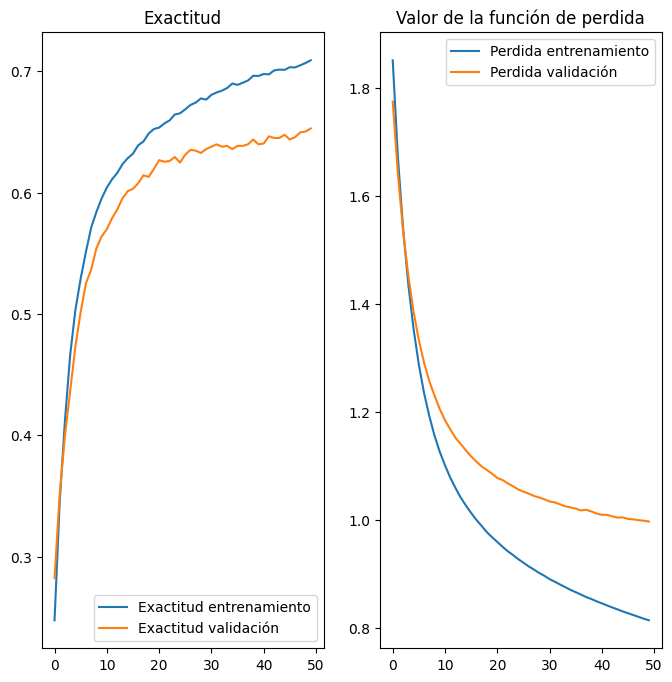

In [20]:
exactitud = historial.history['accuracy']
exactitud_val = historial.history['val_accuracy']

perdida = historial.history['loss']
perdida_val = historial.history['val_loss']

rango_epoca = range(epocas)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(rango_epoca, exactitud, label='Exactitud entrenamiento')
plt.plot(rango_epoca, exactitud_val, label='Exactitud validación')
plt.legend(loc='lower right')
plt.title('Exactitud')

plt.subplot(1, 2, 2)
plt.plot(rango_epoca, perdida, label='Perdida entrenamiento')
plt.plot(rango_epoca, perdida_val, label='Perdida validación')
plt.legend(loc='upper right')
plt.title('Valor de la función de perdida')
plt.show()

In [21]:
# Exportamos el modelo construido
modelo_preentrenado.save("/content/drive/MyDrive/M22/Reto/Modelo_2_PreEntrenado.keras")

In [ ]:
#############################################################################
#  6c. El tercer modelo lo debes generar utilizando la herramienta Teachable Machine
# y exportándolo para poder cargarlo en tu cuaderno para compararlo
#############################################################################

# Se generó el archivo converted_keras.zip el contiene el modelo creado por Teachable Machine
# usando las fotos en formato jpg utilizadas para el reto
# este archivo contiene los archivos: keras_model.h5 y labels.txt

In [23]:
# Se carga el modelo generado por Teachable Machine
np.set_printoptions(suppress=True)

TN_model = tf.keras.models.load_model("/content/drive/MyDrive/M22/Reto/keras_model.h5", compile= False)

TN_model.summary()

TN_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

new_model_history = TN_model.fit(datagen.flow(img_entrenamiento, etq_entrenamiento, batch_size=128),
                                  validation_data=(img_prueba,etq_prueba),
                                  epochs=10,
                                  batch_size=128
                                 )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 1280)              410208    
                                                                 
 sequential_3 (Sequential)   (None, 6)                 128700    
                                                                 
Total params: 538908 (2.06 MB)
Trainable params: 524828 (2.00 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________
Epoch 1/10
48/48 [==============================] - 86s 1s/step - loss: 1.9461 - accuracy: 0.4496 - val_loss: 4.4846 - val_accuracy: 0.3399
Epoch 2/10
48/48 [==============================] - 64s 1s/step - loss: 1.1706 - accuracy: 0.5571 - val_loss: 3.1567 - val_accuracy: 0.4073
Epoch 3/10
48/48 [==============================] - 64s 1s/step - loss: 1.0549 - accuracy: 0.6051 - val_loss: 3.3308 - val_accuracy

In [50]:
#############################################################################
# 7. Exporta los 3 modelos creados
#############################################################################
# Sólo falta exportar el modelo ya entrenado del que se obtuvo de Teachable Machine
TN_model.save("/content/drive/MyDrive/M22/Reto/Modelo_3_TeachableMachine.keras")

In [ ]:
#############################################################################
# 8.Realiza una comparativa de desempeño para seleccionar el mejor modelo
#############################################################################
# Como se puede apreciar, el modelo imporado del generado por Teachable Machine, muestra una Accuracy del 47.02%
# Mientras que el del modelo preentrenado muestra un accuracy del 65.29%
# Por último, el modelo usando una red convolucional, mostró un accuracy de sólo el 26.45%
# Por lo tanto, el modelo que mejor exactitud mostró fue el generado por la herramienta Teachable Machine

In [26]:
########################################################################################
# 9. Diseña una arquitectura de red neuronal profunda desde cero creando la arquitectura y
# configurando los hiperparámetros.
########################################################################################

RNP = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(5,5),activation='relu',padding='Same', input_shape=(IMG_TAM,IMG_TAM,3)),
    tf.keras.layers.MaxPooling2D((2,2),strides=1, padding='Same'),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(96,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='Same'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(6, activation='softmax')
])

RNP.summary()

RNP.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 224, 224, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 96)      55392     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 96)       

In [27]:
##########################################################################################
# 10. Entrena y ajusta la red neuronal profunda diseñada y al final exporta el modelo generado
##########################################################################################
evolucion = RNP.fit(datagen.flow(img_entrenamiento, etq_entrenamiento, batch_size=128),
                    validation_data =(img_prueba,etq_prueba),
                    epochs=50,
                    batch_size=128
                   )


Epoch 1/50
48/48 [==============================] - 74s 1s/step - loss: 1.9390 - accuracy: 0.2132 - val_loss: 1.7808 - val_accuracy: 0.2174
Epoch 2/50
48/48 [==============================] - 64s 1s/step - loss: 1.7676 - accuracy: 0.2295 - val_loss: 1.7492 - val_accuracy: 0.2266
Epoch 3/50
48/48 [==============================] - 64s 1s/step - loss: 1.7419 - accuracy: 0.2498 - val_loss: 1.7189 - val_accuracy: 0.3039
Epoch 4/50
48/48 [==============================] - 64s 1s/step - loss: 1.7085 - accuracy: 0.2867 - val_loss: 1.6799 - val_accuracy: 0.3052
Epoch 5/50
48/48 [==============================] - 64s 1s/step - loss: 1.6905 - accuracy: 0.2926 - val_loss: 1.6462 - val_accuracy: 0.3117
Epoch 6/50
48/48 [==============================] - 64s 1s/step - loss: 1.6597 - accuracy: 0.3086 - val_loss: 1.5976 - val_accuracy: 0.3353
Epoch 7/50
48/48 [==============================] - 64s 1s/step - loss: 1.6534 - accuracy: 0.3204 - val_loss: 1.5985 - val_accuracy: 0.3556
Epoch 8/50
48/48 [==

In [28]:
# Guardamos el modelo construido
RNP.save("/content/drive/MyDrive/M22/Reto/Modelo_4_redConvProfunda.keras")

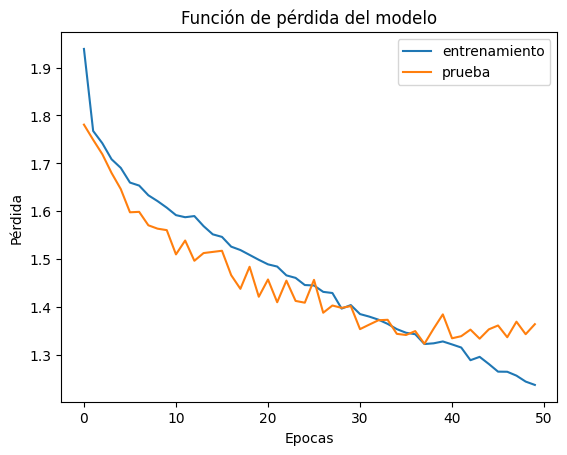

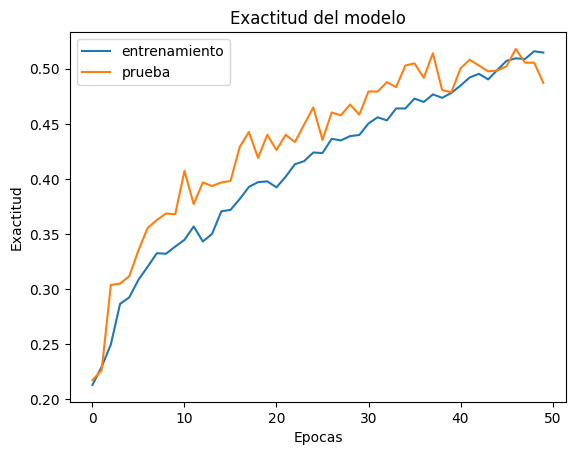

In [29]:
# Realizamos medición del desempeño de este modelo
plt.plot(evolucion.history['loss'])
plt.plot(evolucion.history['val_loss'])
plt.title('Función de pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Epocas')
plt.legend(['entrenamiento', 'prueba'])
plt.show()

plt.plot(evolucion.history['accuracy'])
plt.plot(evolucion.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Epocas')
plt.legend(['entrenamiento', 'prueba'])
plt.show()

In [34]:
##############################################################
# 11. Diseña una arquitectura de red neuronal profunda utilizando un modelo pre-entrenado
##############################################################
dnn_model = tf.keras.Sequential()

imported_model= tf.keras.applications.MobileNetV2(input_shape=(IMG_TAM,IMG_TAM,3),
                                                  include_top=False,
                                                  classes=6,
                                                  weights='imagenet')

for layer in imported_model.layers:
    layer.trainable=False

dnn_model.add(imported_model)
dnn_model.add(tf.keras.layers.Conv2D(32,(5,5),activation='relu',strides=(1,1),padding='Same', input_shape=(IMG_TAM,IMG_TAM,3)))
dnn_model.add(tf.keras.layers.MaxPooling2D((2,2)))
dnn_model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='Same'))
dnn_model.add(tf.keras.layers.MaxPooling2D((2,2)))

dnn_model.add(tf.keras.layers.Flatten())
dnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
dnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
dnn_model.add(tf.keras.layers.Dense(32, activation='relu'))
dnn_model.add(tf.keras.layers.Dense(6, activation='softmax'))


dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 32)          1024032   
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 3, 3, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 1, 1, 64)          0         
 ng2D)                                                           
                                                     

In [35]:
##############################################################
# 12. Entrena y ajusta la red neuronal profunda diseñada y al final exporta el modelo
##############################################################
dnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

dnn_history = dnn_model.fit(img_entrenamiento,
                        etq_entrenamiento,
                        validation_data=(img_prueba,etq_prueba),
                        epochs=10
)

Epoch 1/10
191/191 [==============================] - 11s 35ms/step - loss: 1.2089 - accuracy: 0.5514 - val_loss: 0.9898 - val_accuracy: 0.6437
Epoch 2/10
191/191 [==============================] - 4s 20ms/step - loss: 0.8315 - accuracy: 0.7035 - val_loss: 0.9537 - val_accuracy: 0.6621
Epoch 3/10
191/191 [==============================] - 4s 20ms/step - loss: 0.6501 - accuracy: 0.7660 - val_loss: 0.9392 - val_accuracy: 0.6798
Epoch 4/10
191/191 [==============================] - 4s 20ms/step - loss: 0.4961 - accuracy: 0.8179 - val_loss: 1.0719 - val_accuracy: 0.6765
Epoch 5/10
191/191 [==============================] - 4s 20ms/step - loss: 0.3937 - accuracy: 0.8474 - val_loss: 1.1325 - val_accuracy: 0.6673
Epoch 6/10
191/191 [==============================] - 4s 20ms/step - loss: 0.3229 - accuracy: 0.8690 - val_loss: 1.3383 - val_accuracy: 0.6758
Epoch 7/10
191/191 [==============================] - 4s 20ms/step - loss: 0.2622 - accuracy: 0.8928 - val_loss: 1.3590 - val_accuracy: 0.660

In [51]:
# Exportamos el modelo
dnn_model.save("/content/drive/MyDrive/M22/Reto/Modelo_5_redPreEntrenadaConvProfunda.keras")

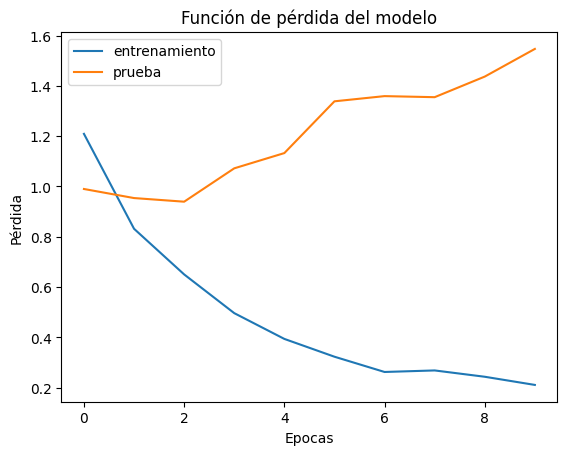

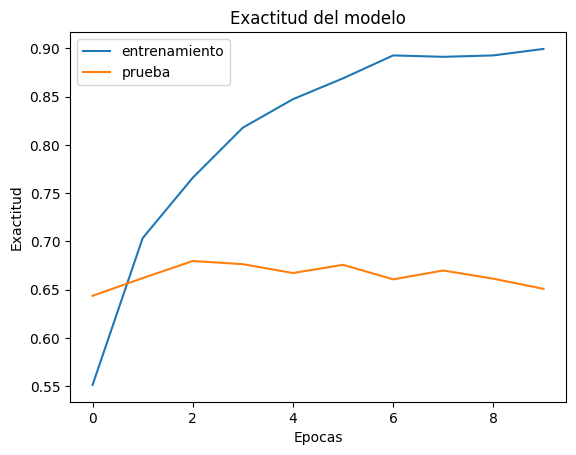

In [36]:
# Realizamos medición del desempeño de este modelo
plt.plot(dnn_history.history['loss'])
plt.plot(dnn_history.history['val_loss'])
plt.title('Función de pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Epocas')
plt.legend(['entrenamiento', 'prueba'])
plt.show()

plt.plot(dnn_history.history['accuracy'])
plt.plot(dnn_history.history['val_accuracy'])
plt.title('Exactitud del modelo')
plt.ylabel('Exactitud')
plt.xlabel('Epocas')
plt.legend(['entrenamiento', 'prueba'])
plt.show()

In [39]:
##############################################################
# 13. Genera un modelo utilizando la herramienta Teachable Machine utilizando solamente el
# conjunto de entrenamiento y al final exporta el modelo
##############################################################

new_model = tf.keras.models.load_model("/content/drive/MyDrive/M22/Reto/keras_model.h5")

new_model.summary()

new_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

new_model_history = new_model.fit(img_entrenamiento,
                                  etq_entrenamiento,
                                  #validation_data=(img_prueba,etq_prueba),
                                  epochs=10
                                 )

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 1280)              410208    
                                                                 
 sequential_3 (Sequential)   (None, 6)                 128700    
                                                                 
Total params: 538908 (2.06 MB)
Trainable params: 524828 (2.00 MB)
Non-trainable params: 14080 (55.00 KB)
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 28s 39ms/step - loss: 1.5199 - accuracy: 0.5269
Epoch 2/10
191/191 [==============================] - 7s 38ms/step - loss: 0.9250 - accuracy: 0.6567
Epoch 3/10
191/191 [==============================] - 7s 38ms/step - loss: 0.7749 - accuracy: 0.7084
Epoch 4/10
191/191 [==============================] - 7s 38ms/step - loss: 0.7083 - accuracy: 0.7351
Epoch 

In [52]:
# Guardamos el modelo construido
new_model.save("/content/drive/MyDrive/M22/Reto/Modelo_6_TeachableMachine.keras")

In [53]:
##############################################################
# 14. Importa los tres modelos generados y compara su desempeño usando el conjunto de
# prueba y el valor de exactitud
##############################################################
modelo_1 = tf.keras.models.load_model("/content/drive/MyDrive/M22/Reto/Modelo_4_redConvProfunda.keras")
modelo_1.summary()
modelo_1.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
modelo_1_history = modelo_1.fit(img_entrenamiento,
                                etq_entrenamiento,
                                validation_data=(img_prueba,etq_prueba),
                                epochs=10
                               )
print("========================================")
print("Exactitud Modelo 1 (Red Convolucional)")
print(modelo_1_history.history['val_accuracy'][9])
print("========================================")

modelo_2 = tf.keras.models.load_model("/content/drive/MyDrive/M22/Reto/Modelo_5_redPreEntrenadaConvProfunda.keras")
modelo_2.summary()
modelo_2.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
modelo_2_history = modelo_2.fit(img_entrenamiento,
                                etq_entrenamiento,
                                validation_data=(img_prueba,etq_prueba),
                                epochs=10
                               )
print("========================================")
print("Exactitud Modelo 2 (Red Pre Entrenada)")
print(modelo_2_history.history['val_accuracy'][9])
print("========================================")

modelo_3 = tf.keras.models.load_model("/content/drive/MyDrive/M22/Reto/Modelo_6_TeachableMachine.keras")
modelo_3.summary()
modelo_3.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
modelo_3_history = modelo_3.fit(img_entrenamiento,
                                etq_entrenamiento,
                                validation_data=(img_prueba,etq_prueba),
                                epochs=10
                               )
print("========================================")
print("Exactitud Modelo 3 (Red Teachable Machine)")
print(modelo_3_history.history['val_accuracy'][9])
print("========================================")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 224, 224, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 96)      55392     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 96)       

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 conv2d_18 (Conv2D)          (None, 7, 7, 32)          1024032   
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 3, 3, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 3, 3, 64)          18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 1, 1, 64)          0         
 ng2D)                                                           
                                                     

In [ ]:
##############################################################
# 15. Selecciona el mejor modelo de acuerdo con su desempeño
##############################################################
# Con base en el análisis de los tres modelos, el que mejor resultado obtuvo es el que
#  utiliza un modelo preentrenado; mostrando un exactitud del 59.46%
#
# En contraste, el modelo creado usando una red convolucional, sólo mostró una
# exactitud del 46.23%, mientras que el modelo que utilizó una red creada por Teachable Machine
# sólo mostró una exactitud del 44.33%
#
# De cualquier modo, todos estos valores obtenidos al utilizar redes neuronales profundas
# son superiores a los obtendios por las redes neuronales simples; demostrando así
# la efectividad de las redes neuronales profundas respecto a las redes neuronales simples
